In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from typing import Callable

pd.set_option("display.max.columns", 50)
pd.set_option("precision", 1)
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
DATADIR = os.path.join("..", "data")
LOGDIR = os.path.join("..", "logs")

strategies = [
    "naive_random",
    "greedy_random",
    "greedy_eigenvector",
    "greedy_diameter"
]

In [ ]:
#Parse tables and reduce the simul data a bit and engineer a few features of the summaries

results = pd.read_pickle(os.path.join(DATADIR, "simul_results", "second_batch.pkl"))
results = (
    results
    .groupby(["strategy", "group"]).mean()
    .loc[:, lambda df: df.columns.get_level_values(1).isin([0.25, 1.0])]
    .unstack(level=0)
    .loc[:, lambda df: df.columns.get_level_values(2).isin(strategies)]
)

results.columns = results.columns.to_flat_index()
results.columns = [f"{x[0]}_{str(x[1])}_{x[2]}" for x in results.columns]
results = results.reset_index().rename({"group": "name"}, axis=1)


summaries = pd.read_pickle(os.path.join(DATADIR, "processed_data", "network_summaries.pkl"))
summaries["density"] = summaries.degree_mean / (summaries.nodes - 1)
summaries["eig_cent_range"] = summaries.eig_cent_max - summaries.eig_cent_min
summaries["eig_cent_ratio"] = summaries.eig_cent_max / summaries.eig_cent_min
summaries["eig_cent_logratio"] = np.log(summaries["eig_cent_ratio"])
summaries["degree_range"] = summaries.degree_max - summaries.degree_min
summaries["degree_ratio"] = summaries.degree_max / summaries.degree_min
summaries = summaries.drop(index=6)

#Merge together
summaries = pd.merge(summaries, results, on=["name"]).set_index("name")


#Helper histogram explore function
def explore_hist(
    col:str, 
    filter_func:Callable = None, 
    df:pd.DataFrame = summaries, 
    ascending:bool = False
    ):
    df[col].plot(kind='hist', subplots=True, title=col)
    if filter_func == None:
        filter_func = lambda x: x[col] > 0
    print(df[filter_func].sort_values(by=col, ascending=ascending)[col])

In [ ]:
summaries.describe()

In [22]:
summaries

,nodes,edges,degree_mean,degree_max,degree_min,diameter,triangles,average_clustering,eig_cent_mean,eig_cent_max,eig_cent_min,density,eig_cent_range,eig_cent_ratio,eig_cent_logratio,degree_range,degree_ratio,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,caught_rel_0.25_greedy_eigenvector,caught_rel_0.25_greedy_random,caught_rel_0.25_naive_random,caught_rel_1.0_greedy_eigenvector,caught_rel_1.0_greedy_random,caught_rel_1.0_naive_random,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
togo,33,47,2.8,19,1,4,14,0.5,1.4e-01,0.6,3.2e-02,8.9e-02,0.6,18.6,2.9,18,19.0,61.1,62.4,74.6,274.3,272.9,277.2,4.7,5.6,5.3,274.3,272.9,277.2,31.4,32.0,47.7,274.3,272.9,277.2
mali_terrorists,36,67,3.7,11,1,7,43,0.4,1.2e-01,0.4,7.2e-03,1.1e-01,0.4,53.2,4.0,10,11.0,52.7,55.2,67.7,267.7,265.3,279.4,9.1,9.2,9.8,267.7,265.3,279.4,47.2,50.1,63.4,267.7,265.3,279.4
london_gang,54,315,11.7,25,2,4,4321,0.6,1.1e-01,0.2,8.8e-03,2.2e-01,0.2,28.4,3.3,23,12.5,53.7,52.3,81.9,190.6,194.3,228.7,38.8,36.5,54.8,190.6,194.3,228.7,42.7,41.5,67.8,190.6,194.3,228.7
Islamic_state_group,25,27,2.2,9,1,4,3,0.1,1.6e-01,0.5,4.4e-02,9.0e-02,0.5,12.4,2.5,8,9.0,53.2,54.2,59.0,223.1,231.6,229.1,4.4,4.9,4.2,223.1,231.6,229.1,31.1,31.0,33.8,223.1,231.6,229.1
heroin_natarjan,38,87,4.6,20,1,4,46,0.4,1.4e-01,0.4,3.3e-02,1.2e-01,0.4,12.9,2.6,19,20.0,58.2,58.6,81.4,235.2,239.7,272.4,14.8,15.0,17.6,235.2,239.7,272.4,42.4,43.3,65.3,235.2,239.7,272.4
italian_gangs,65,113,3.5,21,1,6,57,0.4,9.3e-02,0.4,6.9e-03,5.4e-02,0.4,63.6,4.2,20,21.0,103.2,105.4,139.2,501.0,495.0,532.2,11.1,9.7,11.8,501.0,495.0,532.2,49.8,56.7,91.4,501.0,495.0,532.2
cocaine_mambo,31,58,3.7,15,1,4,35,0.4,1.4e-01,0.5,2.0e-02,1.2e-01,0.4,23.6,3.2,14,15.0,48.5,47.0,64.4,229.8,225.8,242.6,11.3,10.9,12.5,229.8,225.8,242.6,33.6,32.2,50.4,229.8,225.8,242.6
cocaine_jake,38,50,2.6,12,1,4,15,0.1,1.2e-01,0.5,2.7e-02,7.1e-02,0.4,16.6,2.8,11,12.0,68.4,67.2,84.7,336.0,334.3,341.9,7.3,6.3,7.3,336.0,334.3,341.9,41.9,40.5,54.6,336.0,334.3,341.9
17Nov_greece,18,46,5.1,17,1,2,940,0.7,2.0e-01,0.4,6.3e-02,3.0e-01,0.4,7.2,2.0,16,17.0,28.8,30.2,36.0,107.0,107.0,116.2,11.3,11.5,14.2,107.0,107.0,116.2,23.8,25.9,29.4,107.0,107.0,116.2


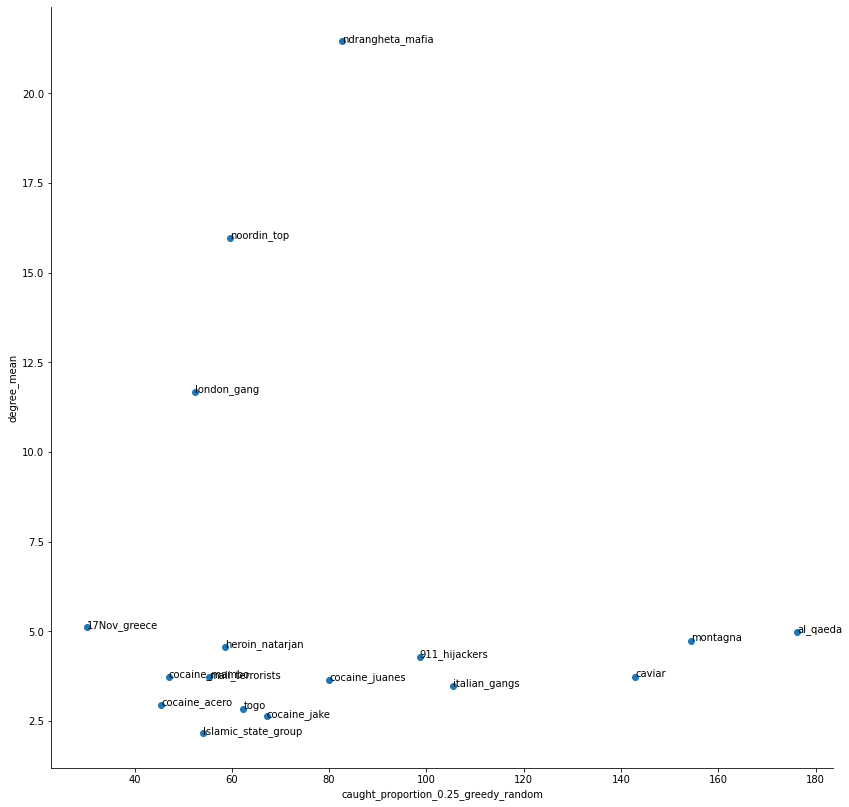

In [38]:
xlabel = "caught_proportion_0.25_greedy_random"
ylabel = "degree_mean"

def labelled_scatter(xlabel, ylabel, data, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 14))

    ax.scatter(xlabel, ylabel, data=data)
    for i in data.index:
        ax.text(x=data.loc[i, xlabel], y=data.loc[i, ylabel], s=i)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    if ax is None:
        return fig

fig = labelled_scatter(xlabel, ylabel, summaries)

Based on Measures of density: we see that the most dense are ndrangheta_mafia, 17Nov_greece, noordin and london. Al Qaeda is really just middle of the pack

In [ ]:
explore_hist("density", lambda x: x["density"] > 0.2)

In [ ]:
explore_hist("average_clustering", lambda x: x["average_clustering"] > 0.5)

Exploring the eigenvalues. Nov Greece is a bit higher than everyone else in terms of mean. Al Qaeda is bottom of the barrel for mean eigenvector centrality. It also has the lowest minimum eigenvector centrality and an astronomical ratio between max and min. This is likely its success considering especially how we are calculating success. A number of networks are also obviously in an upper echeclon of ratios. 

In [ ]:
explore_hist("eig_cent_mean")

In [ ]:
explore_hist("eig_cent_logratio", lambda x: x["eig_cent_logratio"] > 5)

In [ ]:
#Quick and dirty log transform
plt.hist(np.log(np.array(summaries["eig_cent_ratio"].to_list())))

In [ ]:
explore_hist("eig_cent_max")

In [ ]:
explore_hist("eig_cent_min", lambda x: x["eig_cent_min"] < 0.01)

Al qaeda is really just middle of the pack more or less in mean degree. Ndrangheta mafia is a claer high along wiht noordin and london gang. Note that although al qaeda has astronomical eigenvector centrality ratio it does not have a really high degree ratio. 

In [ ]:
explore_hist("degree_mean", lambda x: x["degree_mean"] > 4.9)

In [ ]:
explore_hist("degree_max")

In [ ]:
explore_hist("degree_ratio", lambda x: x["degree_ratio"] > 25)

In [ ]:
explore_hist("degree_range", lambda x: x["degree_range"] > 30)

Clear importance here of high diameter of al_qaeda I would say

In [ ]:
explore_hist("diameter", lambda x: x["diameter"] >= 6)

In [ ]:
explore_hist("eigen_proportion_0.25_greedy_random")